In [1]:
# -- driver_run_forecast_LV2_v1.py  --
# master python script to do a full LV2 forecast simulation

import sys
import pickle
import numpy as np
import os
from datetime import datetime
import gc
import resource
import subprocess

##############

sys.path.append('../sdpm_py_util')

import atm_functions as atmfuns
import ocn_functions as ocnfuns
import grid_functions as grdfuns
import plotting_functions as pltfuns
from get_PFM_info import get_PFM_info
from init_funs import initialize_simulation
from make_LV1_dotin_and_SLURM import make_LV1_dotin_and_SLURM
from run_slurm_LV1 import run_slurm_LV1

level = 2

/home/mspydell/models/PFM_root/PFM/driver/../sdpm_py_util/ocn_functions.py:23: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [ ]:
# need to run the LV1 simulation to make LV1_his.nc
# and get the raw hycom and atm data.  
cmd_list = ['python','-W','ignore','driver_run_forecast_LV1_v4.py']
ret1 = subprocess.run(cmd_list)     


In [2]:
PFM=get_PFM_info()

PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl


In [2]:
# putting atm raw data on to the roms LV2 grid
t1 = datetime.now()
# put the atm data on the roms grid, and rotate the velocities
# everything in this dict turn into the atm.nc file
print('in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
print('doing level: ' + str(level))
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)')
# all the fields plotted with the data on roms grid
t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')



in atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
doing level: 2
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl

ATM on roms grid dict saved with pickle.
return code: 0 (0=good)
done with: atmfuns.get_atm_data_on_roms_grid(ATM,RMG)
this took:
0:00:01.750690




In [2]:
# plot both raw and LV2 atm fields
t1 = datetime.now()
plot_all_atm = 1
if plot_all_atm == 1:
    print('plotting atm and atm on roms grid...')
    pltfuns.plot_all_fields_in_one(str(level))
    print('...done with: pltfuns.plot_all_fields_in_one')

t2 = datetime.now()
print('this took:')
print(t2-t1)
print('\n')


plotting atm and atm on roms grid...
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
...done with: pltfuns.plot_all_fields_in_one
this took:
0:00:10.103977




<Figure size 640x480 with 0 Axes>

In [4]:
# save the atm data into LV2_atm.nc
print('driver_run_forcast_LV2: saving LV2_ATM.nc file')
#atmfuns.atm_roms_dict_to_netcdf(str(level))
cmd_list = ['python','-W','ignore','atm_functions.py','atm_roms_dict_to_netcdf',str(level)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')
print('driver_run_forecast_L21:  done with writing LV2_ATM.nc file.') 
# put in a function to plot the atm.nc file if we want to


driver_run_forcast_LV2: saving LV2_ATM.nc file
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
return code: 0 (0=good)
driver_run_forecast_L21:  done with writing LV2_ATM.nc file.


now making LV1 history file plots
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl
PFM info was loaded from /scratch/PFM_Simulations/PFM_run_info.pkl


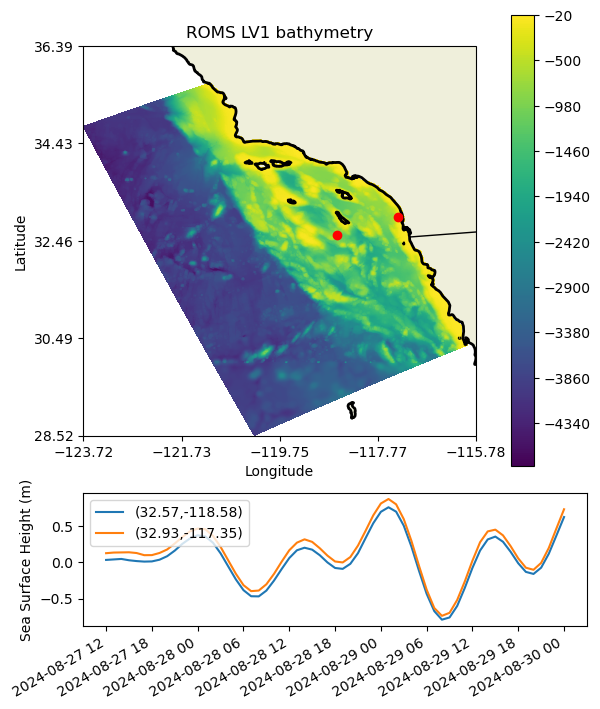

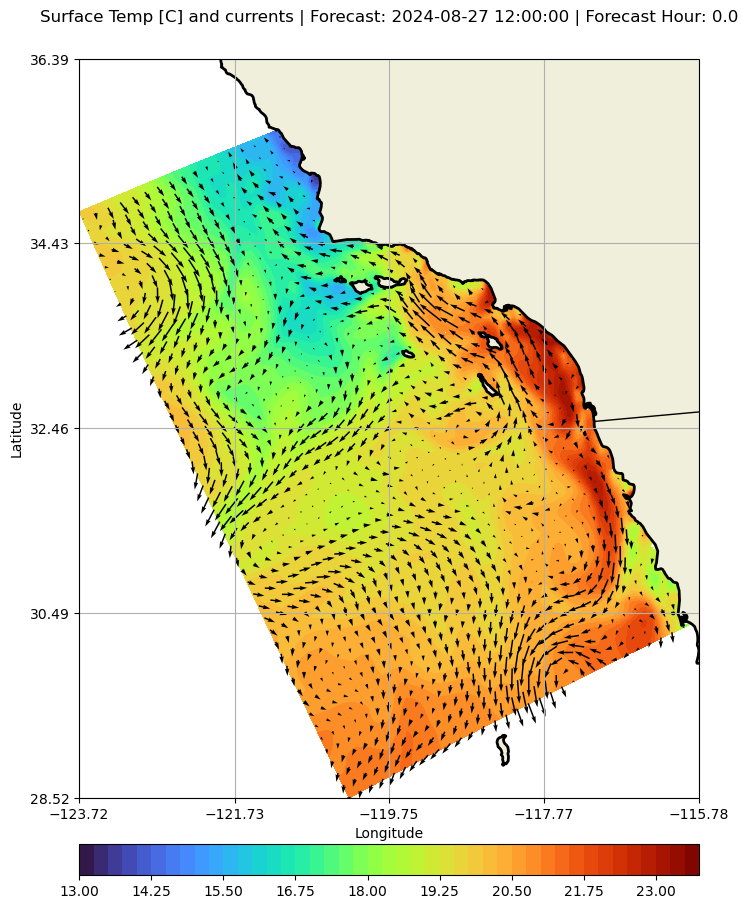

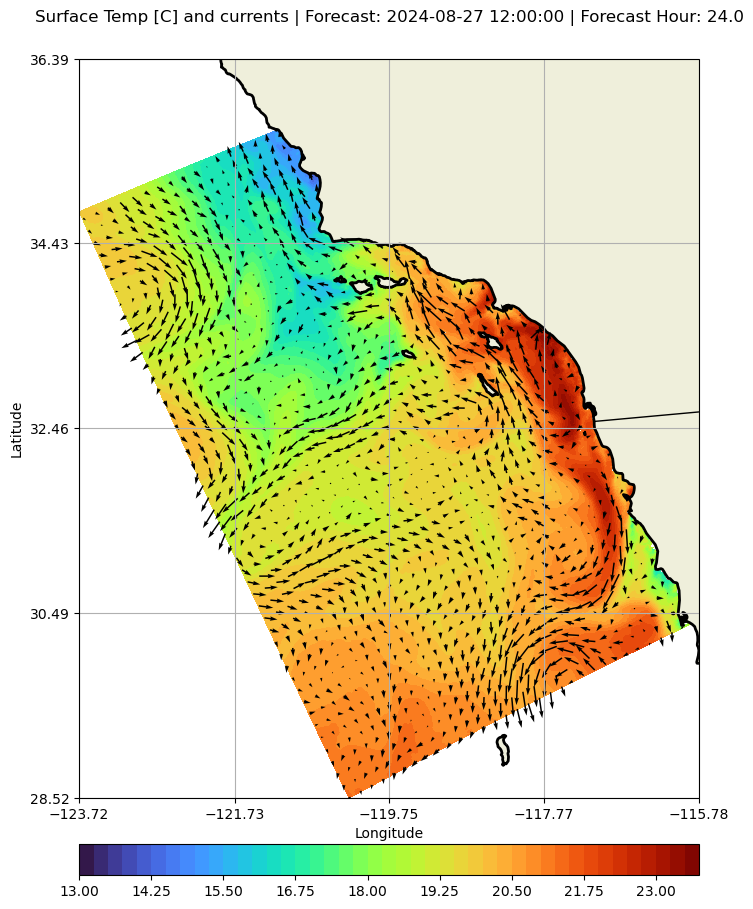

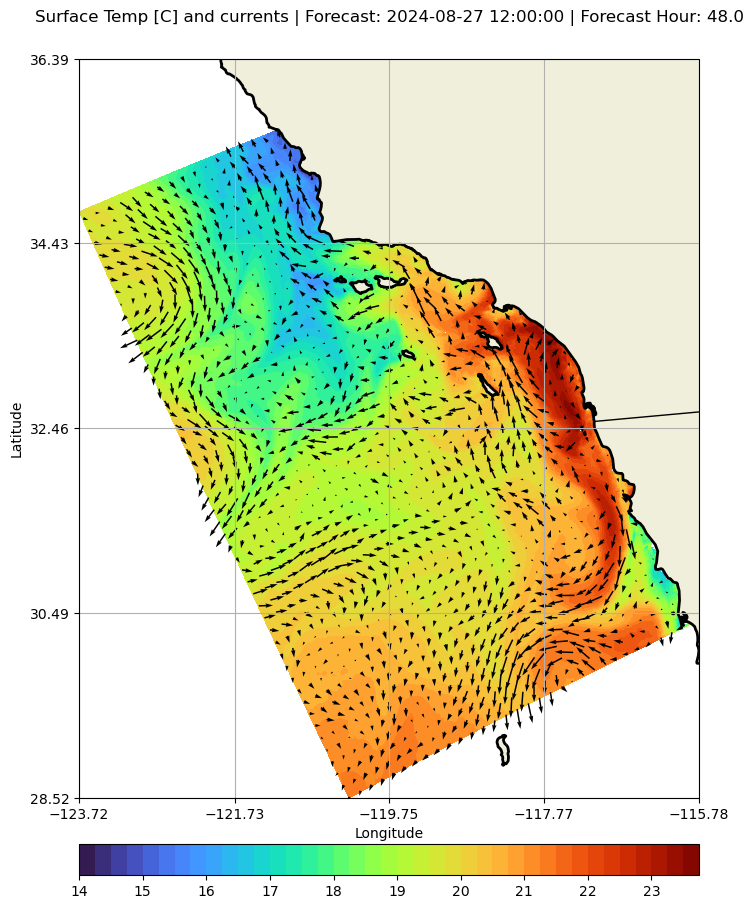

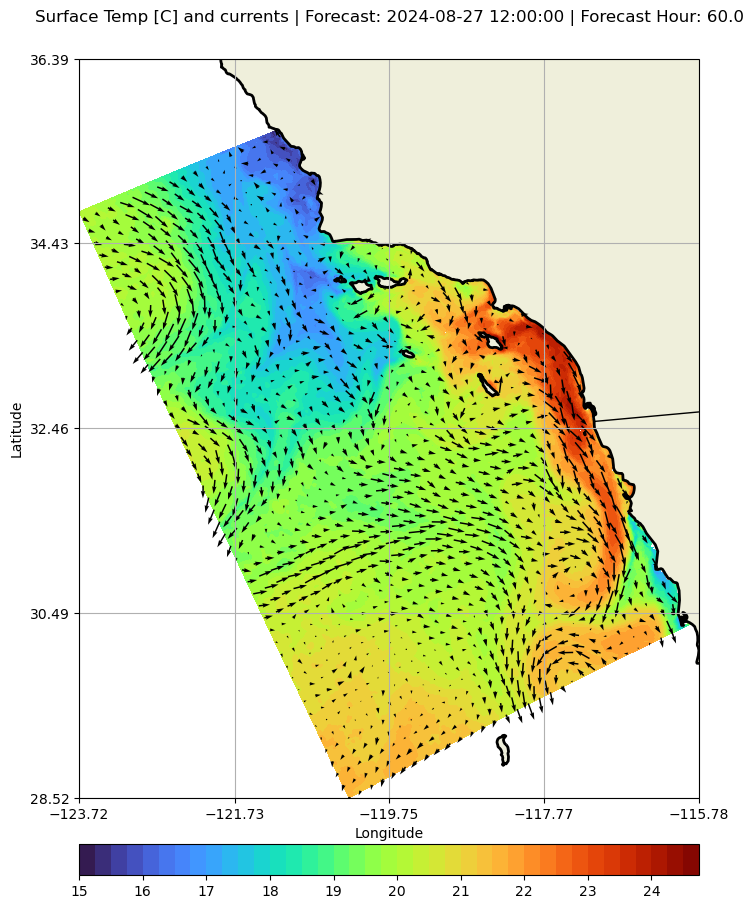

In [2]:
# now making history file plots
print('now making LV1 history file plots')
pltfuns.make_all_his_figures('LV1')
